In [29]:
import httplib
import json

def tmdb_get_latest_movie():
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/latest?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_movie_by_imdb_id(imdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/find/tt"+str(imdb_id)+"?api_key="+api_key+"&external_source=imdb_id", 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_movie_by_tmdb_id(tmdb_id):
    api_key = "7fbe755e9e83c66a573c6482cefd23ed"
    conn = httplib.HTTPSConnection("api.themoviedb.org")
    conn.request("GET", 
                 "/3/movie/"+str(tmdb_id)+"?api_key="+api_key, 
                 "{}")
    return conn.getresponse().read().decode("utf-8")

def tmdb_get_adult(text):
    return json.loads(text)['adult']

def tmdb_get_collection(text):
    return json.loads(text)['belongs_to_collection']

def tmdb_get_budget(text):
    return json.loads(text)['budget']

def tmdb_get_genre(text):
    dict_list = json.loads(text)['genres']
    genre_list = []
    for sub_dict in dict_list:
        genre_list.append(sub_dict['name'])
    return genre_list

def tmdb_get_tmdb_id(text):
    return json.loads(text)['id']

def tmdb_get_imdb_id(text):
    return json.loads(text)['imdb_id'][2::]

def tmdb_get_title(text):
    return json.loads(text)['title']

def tmdb_get_overview(text):
    return json.loads(text)['overview']

def tmdb_get_production_companies(text):
    return json.loads(text)['production_companies']

def tmdb_get_production_countries(text):
    return json.loads(text)['production_countries']

def tmdb_get_release_date(text):
    return json.loads(text)['release_date']

def tmdb_get_runtime(text):
    return json.loads(text)['runtime']

def tmdb_get_spoken_languages(text):
    return json.loads(text)['spoken_languages']

def tmdb_get_poster_url(text):
    url = json.loads(text)['poster_path']
    if url == None:
        return None
    else:
        return "https://image.tmdb.org/t/p/w500" + json.loads(text)['poster_path']

def tmdb_exist(text):
    error_msg = "The resource you requested could not be found."
    if error_msg in text:
        return False
    else:
        return True

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
from os.path import join, expanduser
from os import listdir
from skimage import io
import pickle
import sys
import time

In [37]:
# get file list
dir_path = expanduser("~/tmdb_movie/")
movie_file_list = listdir(dir_path)
poster_list = []

# get posters of all movies
for index, movie_file in enumerate(movie_file_list):
    # get movie text
    with open(join(dir_path, movie_file), "rb") as myfile:
        movie_text = pickle.load(myfile)
    # print progress
    print "\r",index,
    sys.stdout.flush()
    # get poster url
    poster_url = tmdb_get_poster_url(movie_text)
    # check if url exists
    if poster_url == None:
        continue
    else:
        try:
            # get poster
            poster = io.imread(poster_url)
        except:
            print poster_url
            break
        #time.sleep(0.251)
        poster_list.append(poster)

25808 https://image.tmdb.org/t/p/w500/hThjwGiKGoRkK2f8QqQiblQXjGx.jpg


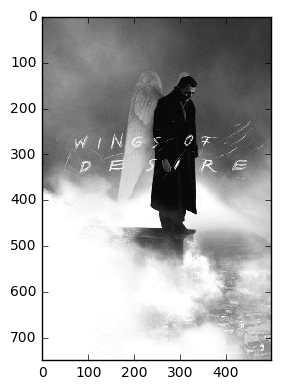

In [44]:
for poster in poster_list:
    if len(poster.shape) < 3:
        io.imshow(poster)
        break

In [40]:
# prepare matrix
poster_oneline_list = []
for poster in poster_list:
    poster_oneline_list.append(poster[0:500, 0:500, :].reshape((1, -1)))
poster_cat = np.concatenate(poster_oneline_list, axis = 0)
print poster_cat.shape
# run pca
from sklearn.decomposition import PCA
pca_model = PCA().fit(poster_cat)
poster_cat_pca = pca_model.transform(poster_cat)
print poster_cat_pca.shape

IndexError: too many indices for array

In [ ]:
pca_1 = pca_model.components_[0].reshape((500, 500, 3))*500
io.imshow(pca_1)